<a href="https://colab.research.google.com/github/finddrive/-openpose-vs-mediapipe/blob/main/M_vs_F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.chdir("/content/drive/MyDrive/DL-pushup-counter")
!ls

mediapipe_out.avi  output_count.avi  __pycache__
model.h5	   posemodule.py     test_video.mov


In [ ]:
!ls

 CASIA-WebFace		        DL-pushup-counter
 CASIA-WebFace_2	        Driver-Drowsiness-Detection
 CASIA-WebFace-masked_2         DriveUploader
 CIS_masked_face_verification   mediapipe
'Colab Notebooks'


## **稠密光流**    
https://github.com/NetoPedro/Deep-Learning-Push-Up-Counter

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import time

model = tf.keras.models.load_model('model.h5')


cap = cv2.VideoCapture("test_video.mov")

fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
out = cv2.VideoWriter('output_count.avi',fourcc, 20.0,(int(cap.get(3)),int(cap.get(4))))

ret, frame1 = cap.read()
# 获取视频宽度
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# 获取视频高度
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255
i= 0
prediction_str = ""
repetitions = 0
up = 0
down = 0
no_move = 0
current_move = 0
initial = -1

start_time = time.time()
counter = 0

#记录帧
store_F_fps = []
tmp = []

while(cap.isOpened()):
    i+=1
    
    ret, frame2 = cap.read()
    if not(ret): break
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    

    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

    image = cv2.resize(rgb, (64, 64))
    image = image.reshape((1,) + image.shape)
    image = image/255.0
    prediction = np.argmax(model.predict(image), axis=-1)[0]
    
    if prediction == 0:
        down +=1 
        if down == 3:
          if initial == -1:
            initial = 0
          if current_move == 2:
            repetitions+=1
          current_move = 0
        elif down > 0:
          up = 0
          no_move = 0
    elif prediction == 2:
        up += 1
        if up == 3 and initial != -1:
          current_move = 2
        elif up > 1:
          down = 0 
          no_move = 0
    else:
        no_move += 1
        if no_move == 15:
          current_move = 1
        elif no_move > 10:
          up = 0
          down = 0 
    counter += 1  # 计算帧数
    
    if (time.time() - start_time) != 0:  # 实时显示帧数
      cv2.putText(frame2, "FPS {0}".format(float('%.1f' % (counter / (time.time() - start_time)))), (30, 430),
                  cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 5)
      tmp.append(round(counter / (time.time() - start_time),2))
      # print("tmp",tmp)
      if len(tmp)==37: # 每60帧一个平均值
        store_F_fps.append(round(np.mean(tmp),2))
        print("storage", store_F_fps)
        tmp = []
      counter = 0
      start_time = time.time()
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (10,400)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 5
    cv2.putText(frame2, "count: "+ str(repetitions),bottomLeftCornerOfText,font, fontScale,fontColor,lineType)
    #out.write(frame2)
    prvs = next

print(store_F_fps)
out.release()
cap.release()
cv2.destroyAllWindows()

storage [6.89]
storage [6.89, 7.22]
storage [6.89, 7.22, 7.06]
storage [6.89, 7.22, 7.06, 6.85]
storage [6.89, 7.22, 7.06, 6.85, 7.17]
storage [6.89, 7.22, 7.06, 6.85, 7.17, 7.17]
storage [6.89, 7.22, 7.06, 6.85, 7.17, 7.17, 7.08]
storage [6.89, 7.22, 7.06, 6.85, 7.17, 7.17, 7.08, 7.18]
storage [6.89, 7.22, 7.06, 6.85, 7.17, 7.17, 7.08, 7.18, 7.13]
storage [6.89, 7.22, 7.06, 6.85, 7.17, 7.17, 7.08, 7.18, 7.13, 6.84]
[6.89, 7.22, 7.06, 6.85, 7.17, 7.17, 7.08, 7.18, 7.13, 6.84]


### **mediapipe**

In [ ]:
!pip install mediapipe

In [ ]:
import cv2
import mediapipe as mp
import os
import time
import datetime
import posemodule as pm
import math

video_path = "test_video.mov"

pTime = 0

start_time = time.time()
fpm_counter = 0

cap = cv2.VideoCapture(video_path)

fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
out = cv2.VideoWriter('mediapipe_out.avi',fourcc, 20.0,(int(cap.get(3)),int(cap.get(4))))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
hight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
detector = pm.poseDetector()

#记录帧
store_M_fps = []
tmp = []


def rescale_frame(frame, percent=75):
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation =cv2.INTER_AREA)


count = 0

f=0
time.sleep(5)
while cap.isOpened():
    success, img = cap.read()
    if not success:
        print("Ignoring empty camera frame.")
        break
    
    # if( width>=800 or hight >=800 ):
    #     img = cv2.resize(img, (int(width/2),int(hight/2)))
    img = detector.findPose(img)
    lmlist = detector.getPosition(img,draw=False)

    
    if len(lmlist)!=0:
        y1 = lmlist[3][2]
        y2 = lmlist[20][2]
        
        length = y2-y1
        if length>=0 and f==0:
            f=1
        elif length<0 and f==1:
            f=0
            count=count+1


        #print(length)

        cTime = time.time()
        fps = 1/(cTime-pTime)
        pTime = cTime
        fpm_counter += 1  # 计算帧数
        if success:
            cv2.putText(img,"Total pull ups: {}".format(int(count)),(5,40),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
            #cv2.imshow("Image",img)
            if (time.time() - start_time) != 0:
              cv2.putText(img, "FPS {0}".format(float('%.1f' % (fpm_counter / (time.time() - start_time)))), (15,45),
                      cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
              # print("FPS: ", fpm_counter / (time.time() - start_time))
              tmp.append(round(fpm_counter / (time.time() - start_time),2))
              print("tmp",tmp)
              if len(tmp)==37: # 每60帧一个平均值
                store_M_fps.append(round(np.mean(tmp),2))
                print("storage", store_M_fps)
                tmp = []
              fpm_counter = 0
              start_time = time.time()
            # out.write(img)
        
        if cv2.waitKey(5) and 0xFF == ord('q') :
            cap.release()
            cv2.destroyAllWindows()
            break



tmp [0.19]
tmp [0.19, 20.8]
tmp [0.19, 20.8, 22.56]
tmp [0.19, 20.8, 22.56, 22.09]
tmp [0.19, 20.8, 22.56, 22.09, 22.91]
tmp [0.19, 20.8, 22.56, 22.09, 22.91, 20.41]
tmp [0.19, 20.8, 22.56, 22.09, 22.91, 20.41, 23.03]
tmp [0.19, 20.8, 22.56, 22.09, 22.91, 20.41, 23.03, 22.45]
tmp [0.19, 20.8, 22.56, 22.09, 22.91, 20.41, 23.03, 22.45, 23.23]
tmp [0.19, 20.8, 22.56, 22.09, 22.91, 20.41, 23.03, 22.45, 23.23, 22.25]
tmp [0.19, 20.8, 22.56, 22.09, 22.91, 20.41, 23.03, 22.45, 23.23, 22.25, 18.34]
tmp [0.19, 20.8, 22.56, 22.09, 22.91, 20.41, 23.03, 22.45, 23.23, 22.25, 18.34, 20.71]
tmp [0.19, 20.8, 22.56, 22.09, 22.91, 20.41, 23.03, 22.45, 23.23, 22.25, 18.34, 20.71, 22.17]
tmp [0.19, 20.8, 22.56, 22.09, 22.91, 20.41, 23.03, 22.45, 23.23, 22.25, 18.34, 20.71, 22.17, 21.53]
tmp [0.19, 20.8, 22.56, 22.09, 22.91, 20.41, 23.03, 22.45, 23.23, 22.25, 18.34, 20.71, 22.17, 21.53, 23.36]
tmp [0.19, 20.8, 22.56, 22.09, 22.91, 20.41, 23.03, 22.45, 23.23, 22.25, 18.34, 20.71, 22.17, 21.53, 23.36, 19.93]

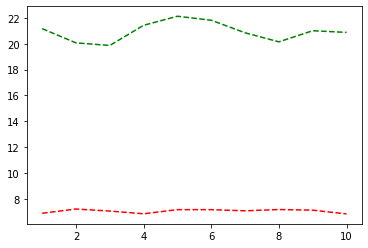

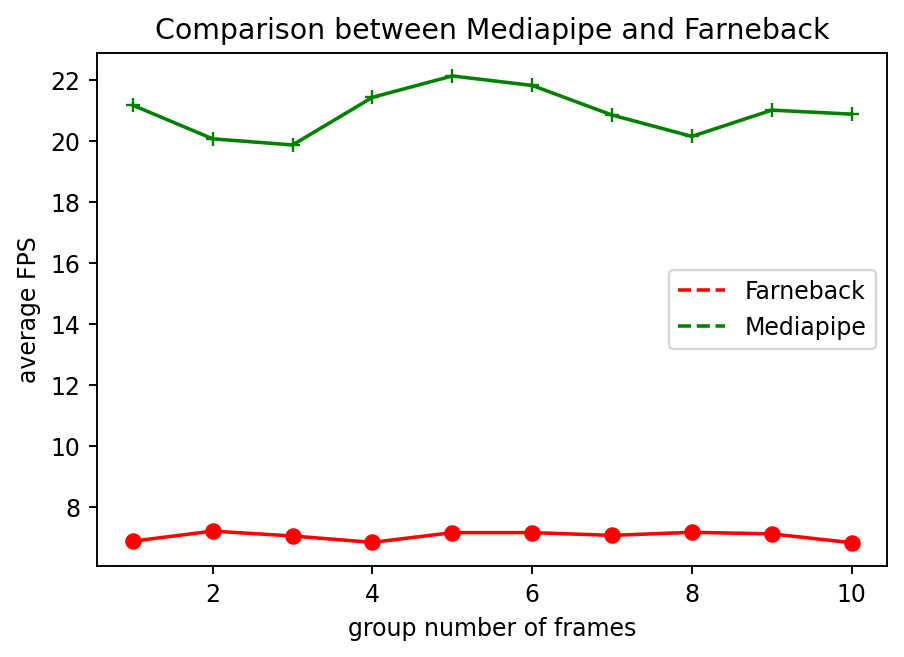

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
F = [6.89, 7.22, 7.06, 6.85, 7.17, 7.17, 7.08, 7.18, 7.13, 6.84]
M = [21.17, 20.07, 19.87, 21.43, 22.13, 21.82, 20.85, 20.15, 21.01, 20.88]
x = [1,2,3,4,5,6,7,8,9,10]

lf, = plt.plot(x,F,'r--',label='Farneback')  #光流
lm, = plt.plot(x,M,'g--',label='Mediapipe')  #mediapipe

plt.figure(dpi=170)
plt.plot(x,F,'ro-',x,M,'g+-')
plt.title('Comparison between Mediapipe and Farneback')
plt.xlabel("group number of frames")
plt.ylabel("average FPS")
plt.legend([lf,lm],['Farneback','Mediapipe'])
plt.show()